# EDA

In [199]:
!pip install wordcloud
!pip install contractions
!pip install gensim
!pip install xgboost
!pip install pyLDAvis

/opt/anaconda3/lib/python3.12/pty.py:95: DeprecationWarning: This process (pid=57620) is multi-threaded, use of forkpty() may lead to deadlocks in the child.
  pid, fd = os.forkpty()


/opt/anaconda3/lib/python3.12/pty.py:95: DeprecationWarning: This process (pid=57620) is multi-threaded, use of forkpty() may lead to deadlocks in the child.
  pid, fd = os.forkpty()


/opt/anaconda3/lib/python3.12/pty.py:95: DeprecationWarning: This process (pid=57620) is multi-threaded, use of forkpty() may lead to deadlocks in the child.
  pid, fd = os.forkpty()


/opt/anaconda3/lib/python3.12/pty.py:95: DeprecationWarning: This process (pid=57620) is multi-threaded, use of forkpty() may lead to deadlocks in the child.
  pid, fd = os.forkpty()


/opt/anaconda3/lib/python3.12/pty.py:95: DeprecationWarning: This process (pid=57620) is multi-threaded, use of forkpty() may lead to deadlocks in the child.
  pid, fd = os.forkpty()


In [215]:
import pandas as pd
data = './TripleA.csv'
df = pd.read_csv(data)
print(df.columns)
print(df["Sentiment"].value_counts())

Index(['Review', 'Sentiment'], dtype='object')
Sentiment
Negative    538
Neutral     262
Positive    200
Name: count, dtype: int64


In [5]:
valid_sentiments = {"Positive", "Neutral", "Negative"}
unique_sentiments = set(df["Sentiment"].unique())

# Find invalid sentiment labels
invalid_sentiments = unique_sentiments - valid_sentiments

if invalid_sentiments:
    print("Unexpected sentiment labels found:", invalid_sentiments)
    invalid_rows = df[df["Sentiment"].isin(invalid_sentiments)]
    print(invalid_rows)
else:
    print("All sentiments are correctly labeled.")

All sentiments are correctly labeled.


In [6]:
df.describe()

,Review,Sentiment
count,1000,1000
unique,1000,3
top,Ive flown with them dozens of times and never ...,Negative
freq,1,538


In [11]:
df.groupby('Sentiment').describe()

Review                                                            \
           count unique                                                top   
Sentiment                                                                    
Negative     538    538  Within Thailand I have good experiences with t...   
Neutral      262    262  Thieving bass still owe me a 1000 usd I will n...   
Positive     200    200  Ive flown with them dozens of times and never ...   

                
          freq  
Sentiment       
Negative     1  
Neutral      1  
Positive     1

In [13]:
df['length']=df['Review'].apply(len)
df.head()

,Review,Sentiment,length
0,Ive flown with them dozens of times and never ...,Positive,66
1,Ive flown AirAsia Thai AirAsia and AirAsia Phi...,Positive,77
2,I have flown with them several times and never...,Positive,155
3,Within Thailand I have good experiences with t...,Negative,164
4,Same experience with AirAsia Japan,Negative,34


In [15]:
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

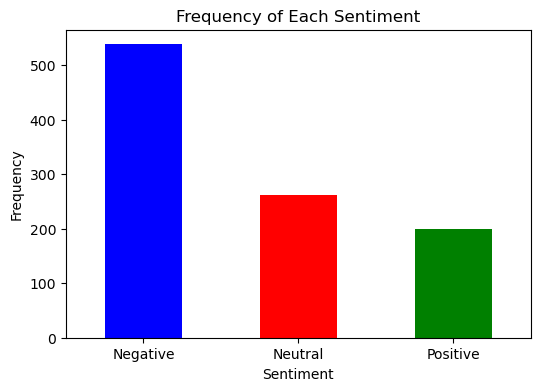

In [16]:
import matplotlib.pyplot as plt

# Count occurrences of each sentiment
sentiment_counts = df['Sentiment'].value_counts()

# Plot bar chart for sentiment distribution
plt.figure(figsize=(6, 4))
sentiment_counts.plot(kind='bar', color=['blue', 'red', 'green'])
plt.xlabel('Sentiment')
plt.ylabel('Frequency')
plt.title('Frequency of Each Sentiment')
plt.xticks(rotation=0)  # Keep labels horizontal
plt.show()


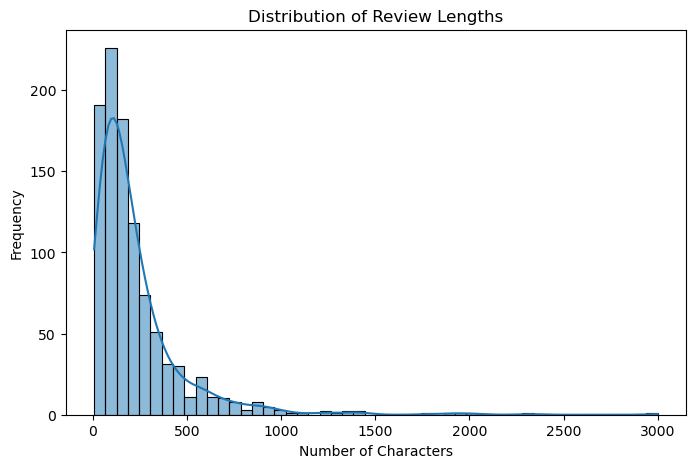

In [19]:
df['Review_Length'] = df['Review'].apply(lambda x: len(str(x)))

# Histogram of review lengths
plt.figure(figsize=(8, 5))
sns.histplot(df['Review_Length'], bins=50, kde=True)
plt.title('Distribution of Review Lengths')
plt.xlabel('Number of Characters')
plt.ylabel('Frequency')
plt.show()


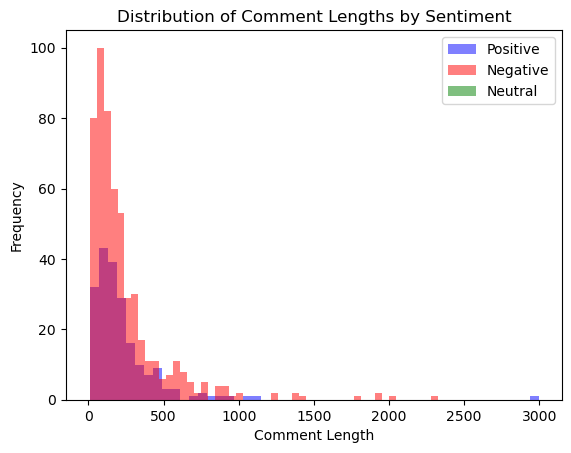

In [21]:
df[df['Sentiment'] == 'Positive']['length'].plot(bins=50, kind='hist', alpha=0.5, label='Positive', color='blue')
df[df['Sentiment'] == 'Negative']['length'].plot(bins=50, kind='hist', alpha=0.5, label='Negative', color='red')
df[df['Sentiment'] == 'neutral']['length'].plot(bins=50, kind='hist', alpha=0.5, label='Neutral', color='green')

plt.legend()
plt.xlabel('Comment Length')
plt.ylabel('Frequency')
plt.title('Distribution of Comment Lengths by Sentiment')
plt.show()


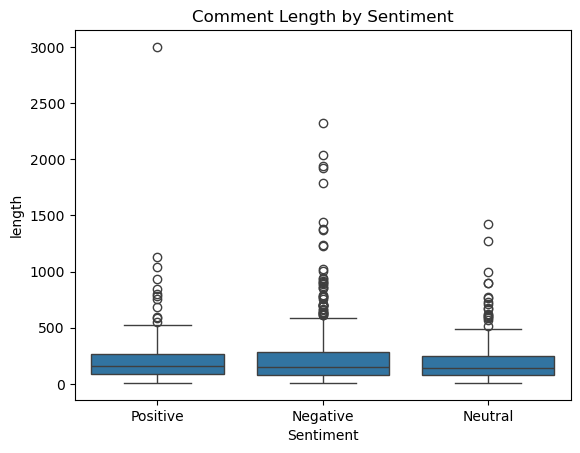

In [23]:
import seaborn as sns

sns.boxplot(x='Sentiment', y='length', data=df)
plt.title('Comment Length by Sentiment')
plt.show()


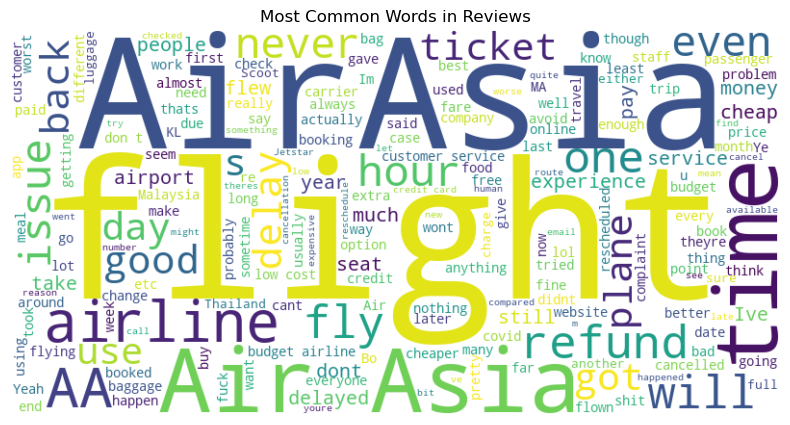

In [25]:
from wordcloud import WordCloud

# Combine all reviews
all_words = ' '.join(df['Review'].dropna())

# Generate word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_words)

# Display word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Most Common Words in Reviews')
plt.show()


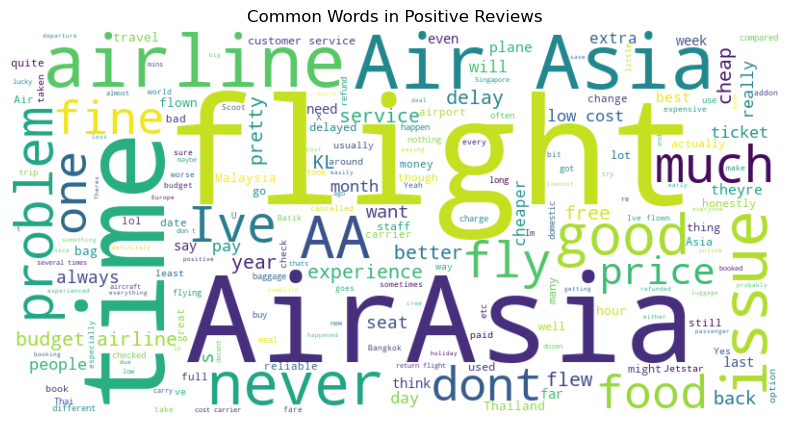

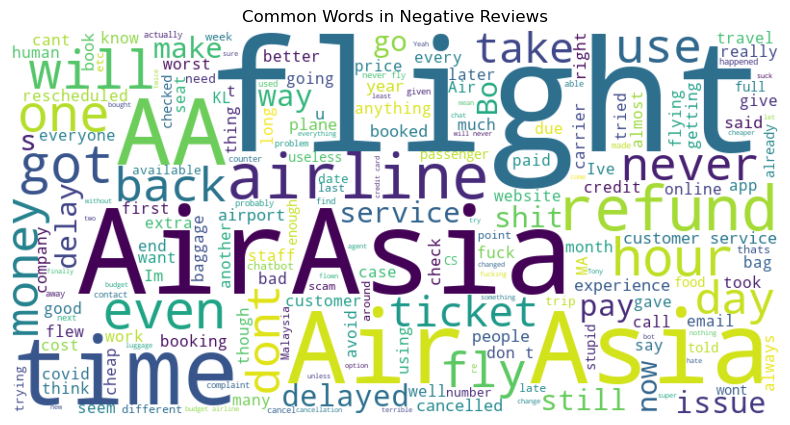

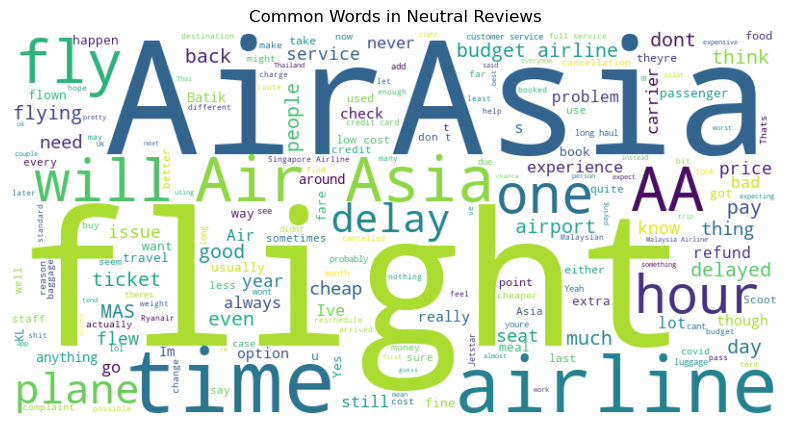

In [27]:
for sentiment in df['Sentiment'].unique():
    text = ' '.join(df[df['Sentiment'] == sentiment]['Review'].dropna())
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f'Common Words in {sentiment} Reviews')
    plt.show()


In [28]:
from sklearn.feature_extraction.text import CountVectorizer

def get_top_ngrams(corpus, n=None, ngram_range=(2, 2)):
    vec = CountVectorizer(stop_words='english', ngram_range=ngram_range).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0)
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq = sorted(words_freq, key=lambda x: x[1], reverse=True)
    return words_freq[:n]

bigrams = get_top_ngrams(df['Review'].dropna(), n=10, ngram_range=(2, 2))
trigrams = get_top_ngrams(df['Review'].dropna(), n=10, ngram_range=(3, 3))

print("Top 10 Bigrams:", bigrams)
print("Top 10 Trigrams:", trigrams)


Top 10 Bigrams: [('air asia', 226), ('customer service', 57), ('budget airlines', 37), ('low cost', 36), ('budget airline', 26), ('credit card', 21), ('ive flown', 19), ('flight delayed', 18), ('pay extra', 15), ('customer support', 14)]
Top 10 Trigrams: [('fly air asia', 13), ('flew air asia', 11), ('low cost airline', 11), ('low cost carrier', 9), ('flown air asia', 7), ('air asia flight', 6), ('air asia worst', 6), ('air asia thailand', 6), ('flying air asia', 5), ('flight delayed hours', 5)]


# Text Preprocessing

## Lowercasing
Convert all text to lowercase to avoid case sensitivity issues.

In [221]:
df['Review'] = df['Review'].str.lower()
df.head()

,Review,Sentiment
0,ive flown with them dozens of times and never ...,Positive
1,ive flown airasia thai airasia and airasia phi...,Positive
2,i have flown with them several times and never...,Positive
3,within thailand i have good experiences with t...,Negative
4,same experience with airasia japan,Negative


## Removing Punctuation

In [224]:
import string
df['Review'] = df['Review'].str.translate(str.maketrans('', '', string.punctuation))

## Removing Numbers

In [227]:
df['Review'] = df['Review'].str.replace(r'\d+', '', regex=True)

## Removing Stopwords

In [230]:
import nltk
from nltk.corpus import stopwords
import contractions

nltk.download('stopwords') #make sure the stopwords are downloaded.

def expand_and_remove_stopwords(text):
    expanded_text = contractions.fix(text) #expands the contractions
    stop_words = set(stopwords.words('english'))
    words = expanded_text.split()
    filtered_words = [word for word in words if word.lower() not in stop_words] #make sure words are lower case for comparison.
    return ' '.join(filtered_words)

df['Review'] = df['Review'].apply(expand_and_remove_stopwords)
df.head()

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/geraint/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


,Review,Sentiment
0,flown dozens times never major issues,Positive
1,flown airasia thai airasia airasia philippines...,Positive
2,flown several times never problems weigh bag t...,Positive
3,within thailand good experiences flew air asia...,Negative
4,experience airasia japan,Negative


## Tokenization

In [233]:
nltk.download('punkt_tab')

from nltk.tokenize import word_tokenize
df['ReviewTokens'] = df['Review'].apply(word_tokenize)

df.head()

[nltk_data] Downloading package punkt_tab to
[nltk_data]     /Users/geraint/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


,Review,Sentiment,ReviewTokens
0,flown dozens times never major issues,Positive,"[flown, dozens, times, never, major, issues]"
1,flown airasia thai airasia airasia philippines...,Positive,"[flown, airasia, thai, airasia, airasia, phili..."
2,flown several times never problems weigh bag t...,Positive,"[flown, several, times, never, problems, weigh..."
3,within thailand good experiences flew air asia...,Negative,"[within, thailand, good, experiences, flew, ai..."
4,experience airasia japan,Negative,"[experience, airasia, japan]"


## Lemmatization

In [236]:
nltk.download('wordnet')

from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()
df['ReviewTokens'] = df['ReviewTokens'].apply(lambda x: [lemmatizer.lemmatize(word) for word in x])

df.head()

[nltk_data] Downloading package wordnet to /Users/geraint/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


,Review,Sentiment,ReviewTokens
0,flown dozens times never major issues,Positive,"[flown, dozen, time, never, major, issue]"
1,flown airasia thai airasia airasia philippines...,Positive,"[flown, airasia, thai, airasia, airasia, phili..."
2,flown several times never problems weigh bag t...,Positive,"[flown, several, time, never, problem, weigh, ..."
3,within thailand good experiences flew air asia...,Negative,"[within, thailand, good, experience, flew, air..."
4,experience airasia japan,Negative,"[experience, airasia, japan]"


# Pipelines

In [242]:
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
from sklearn.model_selection import train_test_split

# Load your dataset
X = df['Review']  # Text data
y = df['Sentiment']  # Target labels

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

classifiers = {
    "Logistic Regression": LogisticRegression(),
    "Random Forest": RandomForestClassifier(),
    "Support Vector Machine": SVC(),
    "Naïve Bayes": MultinomialNB(),
    "Gradient Boosting": GradientBoostingClassifier()
}

results = []

## N-gram Features vs. Unigram Features

In [245]:
ngram_models = {
    "Unigram": CountVectorizer(ngram_range=(1, 1)),
    "Bigram": CountVectorizer(ngram_range=(2, 2)),
    "Trigram": CountVectorizer(ngram_range=(3, 3)),
    "Combined N-Grams": CountVectorizer(ngram_range=(1, 3))
}

In [247]:
# Iterate over classifiers and n-gram models
for clf_name, clf in classifiers.items():
    for ngram_name, vectorizer in ngram_models.items():
        pipeline = Pipeline([
            ('vectorizer', vectorizer),
            ('classifier', clf)
        ])
        
        # Train and test the model
        pipeline.fit(X_train, y_train)
        y_pred = pipeline.predict(X_test)
        
        # Evaluate performance
        accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred, average='weighted')
        recall = recall_score(y_test, y_pred, average='weighted')
        f1 = f1_score(y_test, y_pred, average='weighted')
        
        # Append results to list
        results.append(["N-Gram", clf_name, ngram_name, accuracy, precision, recall, f1])

/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.12/site-pa

## Vector Space 

In [249]:
vector_space_models = {
    "Binary Representation": CountVectorizer(binary=True),
    "Frequency Count": CountVectorizer(),
    "TF-IDF": TfidfVectorizer()
}

In [250]:
for clf_name, clf in classifiers.items():
    for vector_name, vectorizer in vector_space_models.items():
        pipeline = Pipeline([
            ('vectorizer', vectorizer),
            ('classifier', clf)
        ])
        
        # Cross-validation predictions
        y_pred = cross_val_predict(pipeline, X, y, cv=5)
        
        # Evaluate performance
        accuracy = accuracy_score(y, y_pred)
        precision = precision_score(y, y_pred, average='weighted')
        recall = recall_score(y, y_pred, average='weighted')
        f1 = f1_score(y, y_pred, average='weighted')
        
        # Append results to list
        results.append(["Vector Space", clf_name, vector_name, accuracy, precision, recall, f1])

## Word Embeddings

In [252]:
classifiers1 = {
    "Logistic Regression": LogisticRegression(),
    "Random Forest": RandomForestClassifier(),
    "Support Vector Machine": SVC(),
    "Gradient Boosting": GradientBoostingClassifier()
}

In [253]:
# Load pretrained Word2Vec (Google News)
word2vec = api.load("word2vec-google-news-300")

# Load pretrained GloVe
glove_vectors = api.load("glove-wiki-gigaword-50")

# Function to convert text to word embeddings
def get_embedding(text, model):
    words = text.split()
    word_vectors = [model[word] for word in words if word in model]
    return np.mean(word_vectors, axis=0) if word_vectors else np.zeros(model.vector_size)

# Convert text data to embeddings
X_word2vec = np.array([get_embedding(text, word2vec) for text in X])
X_glove = np.array([get_embedding(text, glove_vectors) for text in X])

# Train-test split for word embeddings
X_train_w2v, X_test_w2v, y_train_w2v, y_test_w2v = train_test_split(X_word2vec, y, test_size=0.2, random_state=42)
X_train_glove, X_test_glove, y_train_glove, y_test_glove = train_test_split(X_glove, y, test_size=0.2, random_state=42)

# Test classifiers on word embeddings
for clf_name, clf in classifiers1.items():
    # Word2Vec
    clf.fit(X_train_w2v, y_train_w2v)
    y_pred_w2v = clf.predict(X_test_w2v)
    
    # Evaluate
    accuracy_w2v = accuracy_score(y_test_w2v, y_pred_w2v)
    precision_w2v = precision_score(y_test_w2v, y_pred_w2v, average='weighted')
    recall_w2v = recall_score(y_test_w2v, y_pred_w2v, average='weighted')
    f1_w2v = f1_score(y_test_w2v, y_pred_w2v, average='weighted')
    
    results.append(["Word Embedding", clf_name, "Word2Vec", accuracy_w2v, precision_w2v, recall_w2v, f1_w2v])
    
    # GloVe
    clf.fit(X_train_glove, y_train_glove)
    y_pred_glove = clf.predict(X_test_glove)
    
    # Evaluate
    accuracy_glove = accuracy_score(y_test_glove, y_pred_glove)
    precision_glove = precision_score(y_test_glove, y_pred_glove, average='weighted')
    recall_glove = recall_score(y_test_glove, y_pred_glove, average='weighted')
    f1_glove = f1_score(y_test_glove, y_pred_glove, average='weighted')
    
    results.append(["Word Embedding", clf_name, "GloVe", accuracy_glove, precision_glove, recall_glove, f1_glove])

In [254]:
# Convert results into a DataFrame
df_results = pd.DataFrame(results, columns=["Representation Type", "Classifier", "Feature Type", "Accuracy", "Precision", "Recall", "F1-Score"])

# Apply styling
styled_df = df_results.style.format(precision=4).highlight_max(subset=["Accuracy", "Precision", "Recall", "F1-Score"])

# Display the styled table
display(styled_df)

,Representation Type,Classifier,Feature Type,Accuracy,Precision,Recall,F1-Score
0,N-Gram,Logistic Regression,Unigram,0.5700,0.5484,0.5700,0.5574
1,N-Gram,Logistic Regression,Bigram,0.6100,0.5424,0.6100,0.5067
2,N-Gram,Logistic Regression,Trigram,0.5850,0.3439,0.5850,0.4332
3,N-Gram,Logistic Regression,Combined N-Grams,0.5950,0.5480,0.5950,0.5577
4,N-Gram,Random Forest,Unigram,0.5800,0.5344,0.5800,0.5456
5,N-Gram,Random Forest,Bigram,0.3650,0.4861,0.3650,0.3449
6,N-Gram,Random Forest,Trigram,0.2900,0.6356,0.2900,0.1966
7,N-Gram,Random Forest,Combined N-Grams,0.5950,0.5411,0.5950,0.5033
8,N-Gram,Support Vector Machine,Unigram,0.5950,0.4391,0.5950,0.4634
9,N-Gram,Support Vector Machine,Bigram,0.5850,0.3422,0.5850,0.4318


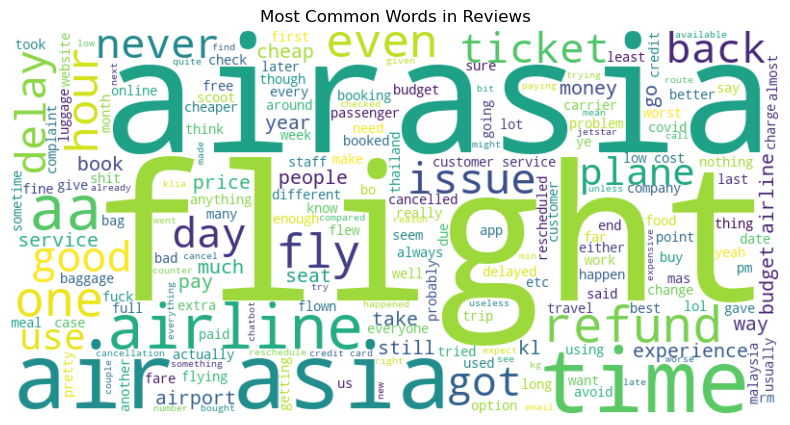

In [255]:
from wordcloud import WordCloud

# Combine all reviews
all_words = ' '.join(df['Review'].dropna())

# Generate word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_words)

# Display word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Most Common Words in Reviews')
plt.show()


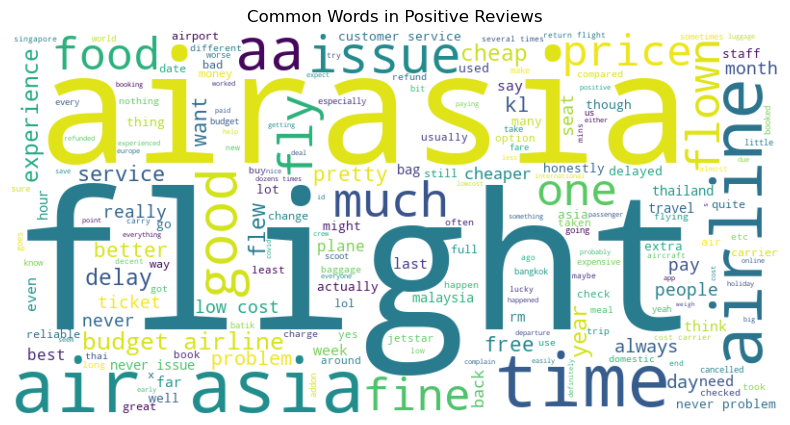

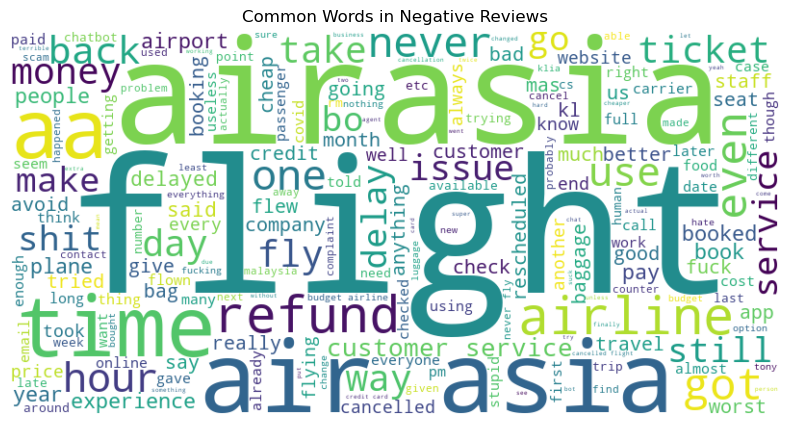

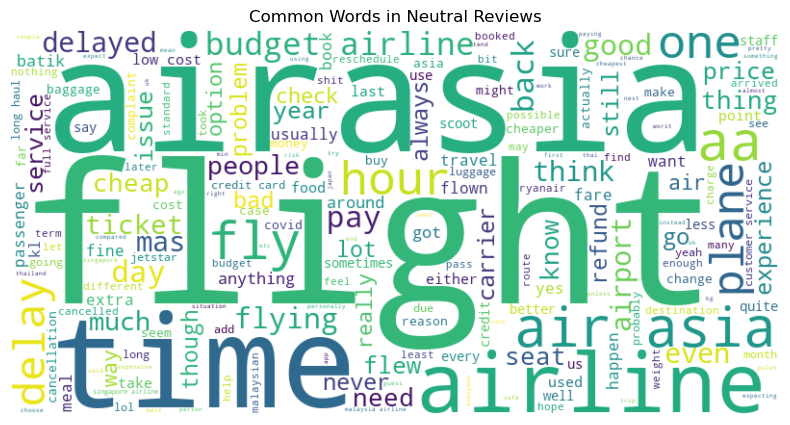

In [256]:
for sentiment in df['Sentiment'].unique():
    text = ' '.join(df[df['Sentiment'] == sentiment]['Review'].dropna())
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f'Common Words in {sentiment} Reviews')
    plt.show()


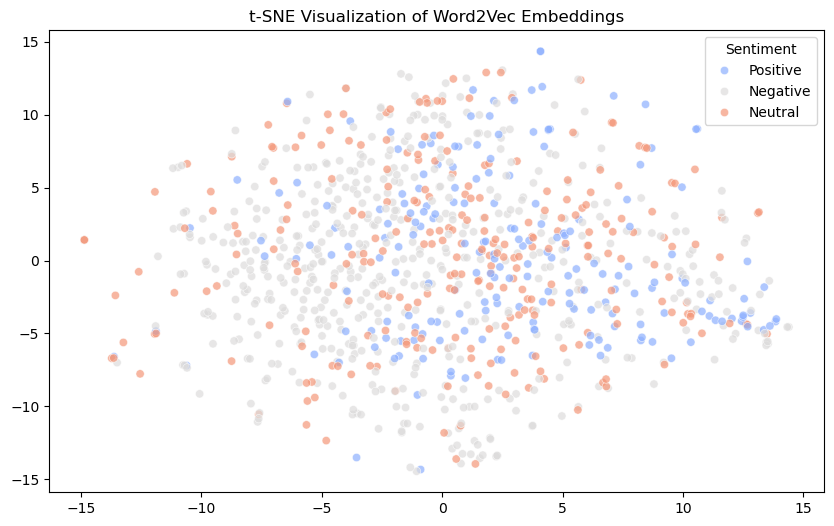

In [257]:
from sklearn.manifold import TSNE
import seaborn as sns

# Reduce dimensionality of Word2Vec embeddings to 2D
tsne = TSNE(n_components=2, random_state=42)
X_embedded = tsne.fit_transform(X_word2vec)  # Replace with X_glove for GloVe

# Scatter plot
plt.figure(figsize=(10, 6))
sns.scatterplot(x=X_embedded[:,0], y=X_embedded[:,1], hue=y, palette="coolwarm", alpha=0.7)
plt.title("t-SNE Visualization of Word2Vec Embeddings")
plt.show()
